In [1]:
import torch
import torchvision

In [2]:
from fastai.vision import *

In [87]:
import struct

class MnistDataset(torch.utils.data.Dataset):
    """Mnist dataset."""

    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        sample, target = self.images[idx], self.labels[idx]
        sample = np.divide(sample, 255.0)
        if self.transform is not None:
            sample = self.transform(sample)
        return sample, target
    
    @classmethod
    def load(cls, images_path, labels_path, valid_percent=0.25, transform=None, need_stats=False):
        images = None
        labels = None
        with open(images_path, 'rb') as f:
            fb_data = f.read()

            offset = 0
            fmt_header = '>iiii'    # 以大端法读取4个 unsinged int32
            magic_number, num_images, num_rows, num_cols = struct.unpack_from(fmt_header, fb_data, offset)
            offset += struct.calcsize(fmt_header)
            fmt_image = '>' + str(num_rows * num_cols) + 'B'
            images = np.empty((num_images, num_rows, num_cols), dtype=np.float32) # 不需要补channel transforms.ToTensor会补
            for i in range(num_images):
                im = struct.unpack_from(fmt_image, fb_data, offset)
                images[i] = np.array(im).reshape((num_rows, num_cols))
                offset += struct.calcsize(fmt_image)
            
        with open(labels_path, 'rb') as f:
            fb_data = f.read()

            offset = 0
            fmt_header = '>ii'    # 以大端法读取2个 unsinged int32
            magic_number, num_labels = struct.unpack_from(fmt_header, fb_data, offset)
            offset += struct.calcsize(fmt_header)
            fmt_image = '>' + str(num_labels) + 'B'
            labels = struct.unpack_from(fmt_image, fb_data, offset)
            labels = np.array(labels)
        
        num_of_train = round(images.shape[0]*(1-valid_percent))
        train_ds = cls(images[:num_of_train], labels[:num_of_train], transform)
        if num_of_train != images.shape[0]: 
            valid_ds = cls(images[num_of_train:], labels[num_of_train:], transform) 
        else:
            valid_ds = None
        result = {'train': train_ds, 'valid': valid_ds}
        if need_stats:
            mean = images.mean()
            std = images.std()
            result['stats'] = [mean, std]
        return result

In [88]:
path = Path('../../data/mnist-raw/')

In [89]:
path.ls()

[PosixPath('../../data/mnist-raw/models'),
 PosixPath('../../data/mnist-raw/train-images-idx3-ubyte'),
 PosixPath('../../data/mnist-raw/train-images-idx3-ubyte.gz'),
 PosixPath('../../data/mnist-raw/train-labels-idx1-ubyte.gz'),
 PosixPath('../../data/mnist-raw/train-labels-idx1-ubyte')]

# 计算统计指标
fastai库中也有mnist的统计指标mnist_stats

In [93]:
datasets = MnistDataset.load(path/'train-images-idx3-ubyte', path/'train-labels-idx1-ubyte', 
                             valid_percent=0.25, 
                             transform=torchvision.transforms.ToTensor(), 
                             need_stats=True)
print(f'mean: {datasets["stats"][0]/255.0}, std: {datasets["stats"][1]/255.0}')

mean: 0.130660576913871, std: 0.3081076229319853


In [94]:
inputs, targets = next(iter(datasets['train']))

In [95]:
inputs.dtype

torch.float32

In [96]:
loader = torch.utils.data.DataLoader(datasets['train'], 
                                     batch_size=8,
                                     shuffle=False, 
                                     num_workers=0)

mean = 0.0
for images, _ in loader:
    batch_samples = images.size(0) 
    images = images.view(batch_samples, images.size(1), -1)
    mean += images.mean(2).sum(0)
mean = mean / len(loader.dataset)

'''
for images, _ in loader:
    batch_samples = images.size(0) 
    images = images.view(batch_samples, images.size(1), -1)
    mean += images.mean((0, 2))
mean = mean / len(loader.dataset)*8.0 # 由于for循环已经把每个batch的mean计算过了所以应该是mean/(len/batch_size)，等同于mean/len*batch_size
'''

var = 0.0
for images, _ in loader:
    batch_samples = images.size(0)
    images = images.view(batch_samples, images.size(1), -1)
    var += ((images - mean.unsqueeze(1))**2).sum([0,2])
std = torch.sqrt(var / (len(loader.dataset)*28*28))
print(mean, std)

tensor([0.1310]) tensor([0.3086])


# 准备数据

In [97]:
data_transforms = {
    'train': torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize([0.131], [0.308])
    ]),
    'valid': torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize([0.131], [0.308])
    ]),
}

In [98]:
datasets = MnistDataset.load(path/'train-images-idx3-ubyte', path/'train-labels-idx1-ubyte', 
                             valid_percent=0.25,
                             transform=data_transforms['train'])

In [99]:
dataloaders = {x: torch.utils.data.DataLoader(datasets[x], batch_size=4,
                                             shuffle=True, num_workers=0)
              for x in ['train', 'valid']}

In [100]:
inputs, targets = next(iter(dataloaders['train']))

In [101]:
inputs.dtype

torch.float32

# 可视化

(2, 2)


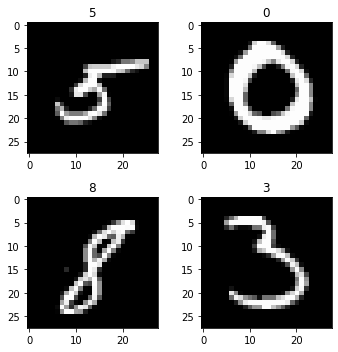

In [102]:
fig, axs = plt.subplots(2, 2, figsize=(5, 5))
print(axs.shape)
for i, axi in enumerate(axs.flat):
    data = inputs[i][0]*0.308+0.131 #denormalize
    axi.imshow(data, cmap=plt.cm.gray)
    axi.set_title(f'{targets[i]}')
plt.tight_layout() #调整子图间距

# 使用fastai

In [103]:
class WrapInput:
    def __init__(self, x):
        self.x = x
    
    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx][0]
    
class WrapTarget:
    def __init__(self, y):
        self.y = y
    
    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.y[idx][1]

In [104]:
class MyBlockModel(nn.Module):

    def __init__(self, num_classes=2, init_weights=True, batch_norm=False):
        super(MyBlockModel, self).__init__()
        #cfgs = [16, 'M', 32, 'M'] #下面层数更多的网络同样的训练轮次和动态学习率比这个错误率更低
        cfgs = [16, 16, 'M', 32, 32, 'M', 32, 32, 'M']
        layers = []
        in_channels = 1
        for v in cfgs:
            if v == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else:
                conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
                if batch_norm:
                    layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
                else:
                    layers += [conv2d, nn.ReLU(inplace=True)]
                in_channels = v
        self.features = nn.Sequential(*layers)
        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))
        self.classifier = nn.Sequential(
            nn.Linear(32 * 7 * 7, 256),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(256, 256), #多加了这一层的作用感觉是训练轮次和损失的曲线更平滑了
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(256, num_classes),
        )
        if init_weights:
            self._initialize_weights()

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

In [105]:
classes = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
train_ds = datasets['train']
train_x = ItemList(WrapInput(train_ds))
train_y = CategoryList(WrapTarget(train_ds), classes)
train_y.c2i = {v:i for i, v in enumerate(classes)}
train_ll = LabelList(train_x, train_y)

In [106]:
valid_ds = datasets['valid']
valid_x = ItemList(WrapInput(valid_ds))
valid_y = CategoryList(WrapTarget(valid_ds), classes)
valid_y.c2i = {v:i for i, v in enumerate(classes)}
valid_ll = LabelList(valid_x, valid_y)

In [107]:
data = LabelLists(path, train_ll, valid_ll).databunch(bs=16, num_workers=0)

In [108]:
def Block(pretrained=False, batch_norm=True, **kwargs):
    model = MyBlockModel(batch_norm=batch_norm, **kwargs)
    return model

In [109]:
learner = cnn_learner(data, Block, metrics=error_rate)

epoch,train_loss,valid_loss,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


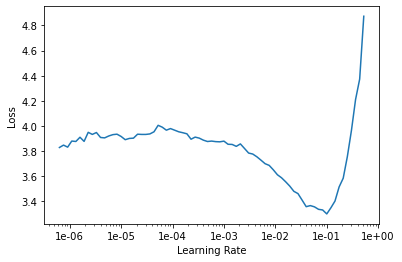

In [111]:
learner.lr_find()
learner.recorder.plot()

In [112]:
learner.fit_one_cycle(8, slice(3e-3, 2e-2))

epoch,train_loss,valid_loss,error_rate,time
0,1.069622,0.668782,0.222067,01:31
1,0.859686,0.466044,0.145133,01:32
2,0.839475,0.362041,0.106333,01:34
3,0.690169,0.314473,0.097067,01:34
4,0.531280,0.225559,0.070333,01:32
5,0.393513,0.199907,0.063067,01:33
6,0.314502,0.151866,0.048133,01:32
7,0.294883,0.145823,0.046333,01:31


In [121]:
for e in inputs:
    print(learner.predict(e))

(Category tensor(5), tensor(5), tensor([8.6738e-07, 1.2050e-03, 8.6873e-05, 7.0512e-03, 4.7054e-07, 9.9139e-01,
        8.8277e-05, 3.4908e-06, 1.6970e-04, 4.4232e-07]))
(Category tensor(0), tensor(0), tensor([9.9946e-01, 1.5649e-05, 1.1474e-05, 1.5822e-06, 3.7103e-06, 7.0109e-07,
        4.8856e-04, 9.0911e-07, 5.5815e-06, 1.5135e-05]))
(Category tensor(8), tensor(8), tensor([1.0312e-02, 9.2104e-04, 1.1161e-03, 7.8361e-05, 4.3731e-04, 7.0909e-05,
        1.6985e-04, 5.4443e-04, 9.8166e-01, 4.6898e-03]))
(Category tensor(3), tensor(3), tensor([1.4718e-06, 8.1182e-05, 5.4879e-05, 9.9836e-01, 1.1727e-05, 1.2881e-03,
        2.4850e-07, 8.0418e-05, 8.6411e-06, 1.1781e-04]))


In [122]:
from torchsummary import summary

In [123]:
summary(learner.model, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 28, 28]             160
       BatchNorm2d-2           [-1, 16, 28, 28]              32
              ReLU-3           [-1, 16, 28, 28]               0
            Conv2d-4           [-1, 16, 28, 28]           2,320
       BatchNorm2d-5           [-1, 16, 28, 28]              32
              ReLU-6           [-1, 16, 28, 28]               0
         MaxPool2d-7           [-1, 16, 14, 14]               0
            Conv2d-8           [-1, 32, 14, 14]           4,640
       BatchNorm2d-9           [-1, 32, 14, 14]              64
             ReLU-10           [-1, 32, 14, 14]               0
           Conv2d-11           [-1, 32, 14, 14]           9,248
      BatchNorm2d-12           [-1, 32, 14, 14]              64
             ReLU-13           [-1, 32, 14, 14]               0
        MaxPool2d-14             [-1, 3

# 使用pytorch

# 总结

custom transform提上日程